In [1]:
import theano
theano.config.exception_verbosity='high'
import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
sns.set_style("ticks")
sns.set_context("poster")

In [2]:
disaster_data = np.ma.masked_values(np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], dtype=np.int64), value=-999,)
year = np.arange(1851, 1962)

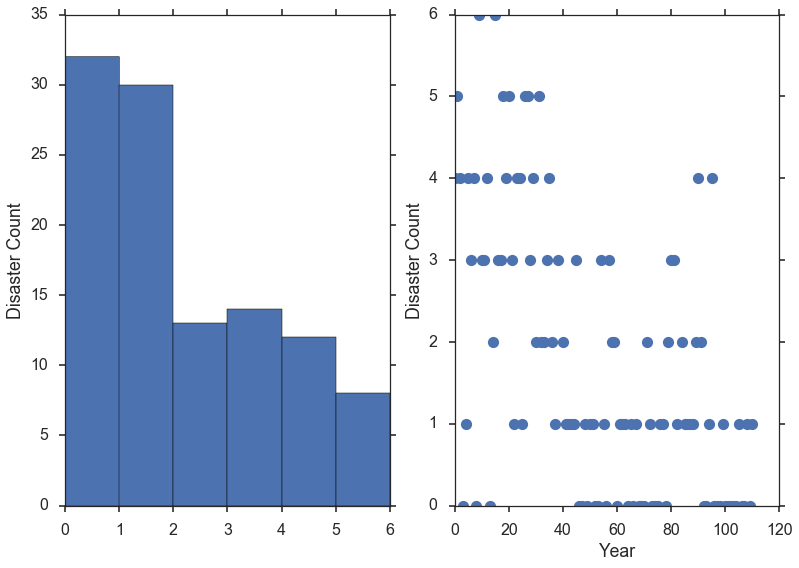

In [3]:
fig, ax = plt.subplots(1,2)

ax[0].hist(disaster_data, bins=range(disaster_data.max() + 1))
ax[1].plot(disaster_data, "o")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Disaster Count")
ax[0].set_ylabel("Disaster Count")

In [4]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.switch(switchpoint >= year, early_rate, late_rate)
    

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

Applied log-transform to early_rate and added transformed early_rate_log to model.
Applied log-transform to late_rate and added transformed late_rate_log to model.


In [5]:
with disaster_model:
    step1 = pm.NUTS([early_rate, late_rate])

    # Use Metropolis for switchpoint, and missing values since it accommodates discrete variables
    step2 = pm.Metropolis([switchpoint, disasters.missing_values[0]] )

    trace = pm.sample(10000, step=[step1, step2])

TypeError: expected type_num 9 (NPY_INT64) got 7
Apply node that caused the error: AdvancedIncSubtensor1{no_inplace,set}(TensorConstant{[   4    5..   0    1]}, Subtensor{int64:int64:}.0, TensorConstant{[39 83]})
Toposort index: 7
Inputs types: [TensorType(int64, vector), TensorType(int64, vector), TensorType(int64, vector)]
Inputs shapes: [(111L,), (2L,), (2L,)]
Inputs strides: [(8L,), (4L,), (8L,)]
Inputs values: ['not shown', array([2, 1]), array([39, 83], dtype=int64)]
Inputs type_num: [9, 7, 9]
Outputs clients: [[Elemwise{Composite{Switch((i0 * GE(i1, i2)), ((Switch(i3, i4, (i1 * i5)) - scalar_gammaln((i6 + i1))) - i7), i4)}}(Elemwise{ge,no_inplace}.0, AdvancedIncSubtensor1{no_inplace,set}.0, TensorConstant{(1L,) of 0}, InplaceDimShuffle{x}.0, TensorConstant{(1L,) of -inf}, Elemwise{log,no_inplace}.0, TensorConstant{(1L,) of 1}, Elemwise{Composite{Switch(GE(i0, i1), i2, i3)}}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-360c93d12d72>", line 13, in <module>
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)
  File "E:\Anaconda\lib\site-packages\pymc3\distributions\distribution.py", line 25, in __new__
    return model.Var(name, dist, data)
  File "E:\Anaconda\lib\site-packages\pymc3\model.py", line 272, in Var
    var = ObservedRV(name=name, data=data, distribution=dist, model=self)
  File "E:\Anaconda\lib\site-packages\pymc3\model.py", line 544, in __init__
    data = as_tensor(data, name,model,distribution.dtype)
  File "E:\Anaconda\lib\site-packages\pymc3\model.py", line 512, in as_tensor
    missing_values)

Debugprint of the apply node: 
AdvancedIncSubtensor1{no_inplace,set} [id A] <TensorType(int64, vector)> ''   
 |TensorConstant{[   4    5..   0    1]} [id B] <TensorType(int64, vector)>
 |Subtensor{int64:int64:} [id C] <TensorType(int64, vector)> ''   
 | |inarray1 [id D] <TensorType(int64, vector)>
 | |Constant{0} [id E] <int64>
 | |Constant{2} [id F] <int64>
 |TensorConstant{[39 83]} [id G] <TensorType(int64, vector)>

Storage map footprint:
 - TensorConstant{[   4    5..   0    1]}, Shape: (111L,), ElemSize: 8 Byte(s), TotalSize: 888 Byte(s)
 - Elemwise{Composite{Switch(GE(i0, i1), i2, i3)}}.0, Shape: (111L,), ElemSize: 8 Byte(s), TotalSize: 888 Byte(s)
 - TensorConstant{[1851 1852..1960 1961]}, Shape: (111L,), ElemSize: 4 Byte(s), TotalSize: 444 Byte(s)
 - Elemwise{ge,no_inplace}.0, Shape: (111L,), ElemSize: 1 Byte(s), TotalSize: 111 Byte(s)
 - TensorConstant{[39 83]}, Shape: (2L,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - early_rate_log_shared, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - inarray1, Input, Shape: (2L,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{int64:int64:}.0, Shape: (2L,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1L,) of 1}, Shape: (1L,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - switchpoint_shared, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - inarray, Input, Shape: (2L,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - late_rate_log_shared, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1L,) of -inf}, Shape: (1L,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1L,) of 0}, Shape: (1L,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 TotalSize: 2416.0 Byte(s) 0.000 GB
 TotalSize inputs: 1417.0 Byte(s) 0.000 GB

